In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-07-29 09:50:24.943211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 09:50:25.202258: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def get_min(Ref, Array):
    return np.argmin(np.abs(Ref - Array))

In [3]:
def add_more_cols(DF):
    DF["P1M"] = (DF["Mjj_msortedP1_high"] + DF["Mjj_msortedP1_low"]) / 2
    DF["P2M"] = (DF["Mjj_msortedP2_high"] + DF["Mjj_msortedP2_low"]) / 2
    DF["P3M"] = (DF["Mjj_msortedP3_high"] + DF["Mjj_msortedP3_low"]) / 2
    
    DF["dRi"] = DF.apply(lambda row: get_min(row["Mjj_avg_dRpairing_GeV"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    DF["Truth_high"] = DF.apply(lambda row: get_min(row["Mass"], np.array([row["Mjj_msortedP1_high"], 
                                row["Mjj_msortedP2_high"], row["Mjj_msortedP3_high"]])), axis = 1)
    DF["Truth_avg"] = DF.apply(lambda row: get_min(row["Mass"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)

In [4]:
def normalize_inouts(DF):
    GevCols = ["Mjj_msortedP1_high", "Mjj_msortedP1_low", "Mjj_msortedP2_high", "Mjj_msortedP2_low", 
               "Mjj_msortedP3_high", "Mjj_msortedP3_low", "Mjj_avg_dRpairing_GeV",
               "pt_ordered_jet1_pt", "pt_ordered_jet2_pt", "pt_ordered_jet3_pt", "pt_ordered_jet4_pt"]
    for GevCol in GevCols:
        DF[GevCol] = DF[GevCol] / 1000
        
    return DF

In [5]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(library="pd")
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    DF["Mass"] = Mass
    add_more_cols(DF)
    normalize_inouts(DF)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [6]:
Masses = [500, 600, 700, 800, 900, 1000]

In [7]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root





Memory used: 0.38549041748046875GB


In [8]:
TrainingDF

,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg
0,1.615654,0.596896,0.527062,0.299362,0.964376,0.382745,0.851550,0.619258,0.483665,0.451035,0.467350,0.552711,-0.114304,2.865723,48.909489,0.444433,-0.196503,-0.791626,49.031044,0.310543,-0.802734,0.283264,29.676029,0.132991,-1.624512,2.250488,20.085930,1,500,673.560446,735.403596,467.350343,2,2,2
1,2.238177,0.702622,0.460715,0.456434,1.572592,0.113801,1.031162,0.472075,1.021581,0.447551,0.843197,0.371984,1.743896,-0.320679,46.217308,0.320978,-1.199951,-2.839844,27.874899,0.152367,1.892090,2.056641,15.250677,0.145358,1.973877,2.810059,13.169145,1,500,843.196643,751.618344,734.565978,0,2,2
2,1.484222,0.685523,0.526373,0.391565,1.017468,0.316771,0.781254,0.199070,0.581170,0.302958,0.490162,0.388197,-1.072021,-0.797729,69.266983,0.249154,1.069092,2.228027,18.476236,0.203515,0.935425,0.786011,28.362259,0.132557,0.517944,-3.092773,12.446876,1,500,667.119136,490.161812,442.064040,1,2,1
3,2.021423,0.657197,0.486695,0.410394,1.328473,0.482107,0.983816,0.400610,0.829579,0.549073,0.692213,0.789828,-1.158203,3.121094,100.617447,0.574557,-1.589355,0.579834,30.443933,0.432090,-1.049805,-1.206299,57.177475,0.127613,-0.431641,1.399902,16.482901,1,500,905.289977,692.212922,689.326225,1,2,2
4,1.884465,0.650958,0.516887,0.294112,1.226707,0.439982,0.974054,0.546845,0.554243,0.553353,0.553798,0.684699,-0.471497,-0.394104,50.539997,0.564449,-0.491882,3.102051,31.160210,0.221250,-1.857910,2.590820,17.524107,0.204233,-0.359375,1.251221,19.098831,1,500,833.344354,760.449872,553.798213,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,1.883865,0.534234,0.460678,0.422482,1.006424,0.397280,0.867855,0.716904,0.795898,0.698575,0.747237,0.618309,0.500854,-2.269531,55.563049,0.353168,1.487549,0.182404,33.703506,0.216941,-0.295593,1.852051,24.621187,0.177280,-1.116699,-0.451782,18.748343,1,1000,701.852326,792.379708,747.236665,2,0,1
599996,3.038430,0.600369,0.408263,0.343466,1.824179,0.904803,1.240478,1.205056,1.043598,1.012563,1.028081,0.987753,0.281311,-2.255371,51.309822,0.706424,-0.620483,1.233887,61.111782,0.522667,0.416992,-0.709473,41.578606,0.387914,1.084717,1.741211,41.066078,1,1000,1364.490847,1222.766722,1028.080867,2,2,2
599997,2.490334,0.684008,0.436359,0.414619,1.703408,0.191076,1.086679,0.648103,1.032539,0.797269,0.947242,0.892392,0.041908,3.074707,122.834137,0.866552,0.054047,0.482971,56.740002,0.298482,0.608643,-0.721558,23.170937,0.242936,1.281494,-0.720215,25.887442,1,1000,947.242015,867.391259,914.904419,0,2,0
599998,2.262540,0.516382,0.450869,0.436098,1.168336,0.176537,1.020110,0.890053,0.986689,0.965553,0.672436,0.601671,-1.545410,-1.525146,50.096973,0.428050,0.348633,-2.219238,41.190102,0.387510,-1.071533,1.309814,41.585361,0.345937,-1.037109,0.887085,44.052132,1,1000,672.436144,955.081704,976.120934,0,2,2


In [9]:
TrainingDF.dtypes

fourjetmasstev               float64
Mjj_msortedP1_high_div4jm    float64
Mjj_msortedP2_high_div4jm    float64
Mjj_msortedP3_high_div4jm    float64
Mjj_msortedP1_high           float64
Mjj_msortedP1_low            float64
Mjj_msortedP2_high           float64
Mjj_msortedP2_low            float64
Mjj_msortedP3_high           float64
Mjj_msortedP3_low            float64
Mjj_avg_dRpairing_GeV        float32
pt_ordered_jet1_pt           float32
pt_ordered_jet1_eta          float32
pt_ordered_jet1_phi          float32
pt_ordered_jet1_m            float32
pt_ordered_jet2_pt           float32
pt_ordered_jet2_eta          float32
pt_ordered_jet2_phi          float32
pt_ordered_jet2_m            float32
pt_ordered_jet3_pt           float32
pt_ordered_jet3_eta          float32
pt_ordered_jet3_phi          float32
pt_ordered_jet3_m            float32
pt_ordered_jet4_pt           float32
pt_ordered_jet4_eta          float32
pt_ordered_jet4_phi          float32
pt_ordered_jet4_m            float32
e

(array([100000., 100000., 100000., 100000., 100000., 100000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

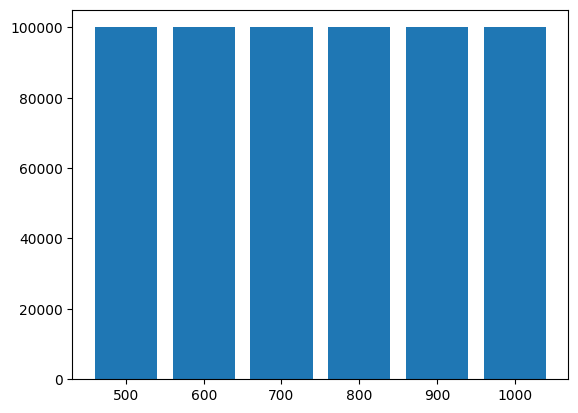

In [10]:
plt.hist(TrainingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

(array([50000., 50000., 50000., 50000., 50000., 50000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

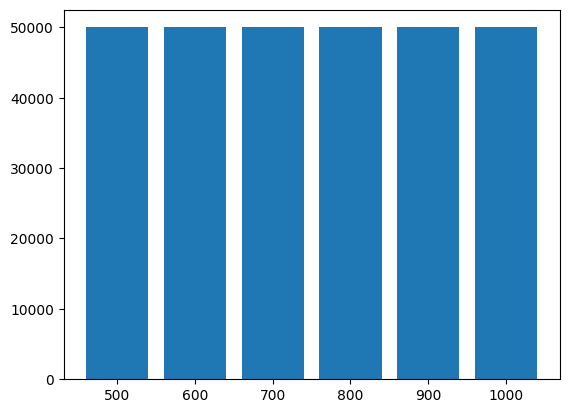

In [11]:
plt.hist(TestingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

In [12]:
TrainingInputs = TrainingDF[["fourjetmasstev", "Mjj_msortedP1_high", 
                             "Mjj_msortedP2_high", "Mjj_msortedP3_high"]].to_numpy()
TrainingTruth = TrainingDF["Truth_high"].to_numpy()

TestingInputs = TestingDF[["fourjetmasstev", "Mjj_msortedP1_high", 
                             "Mjj_msortedP2_high", "Mjj_msortedP3_high"]].to_numpy()

In [13]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(600000, 4)
(600000,)
(300000, 4)


In [14]:
def model_DNN_lite():
    Model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')],
        name = "ModelDNNLite"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [15]:
def model_DNN():
    Model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')],
        name = "ModelDNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [16]:
Model = model_DNN_lite()
#Model = model_DNN()

2023-07-29 09:51:05.358068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 09:51:05.970524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11303 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [17]:
Model.fit(TrainingInputs, TrainingTruth, batch_size = 1024,
          epochs = 20, validation_split = 0.2)

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 0.7924 - accuracy: 0.5893 - val_loss: 1.2179 - val_accuracy: 0.4028
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.6976 - accuracy: 0.6459 - val_loss: 1.1808 - val_accuracy: 0.4326
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6813 - accuracy: 0.6513 - val_loss: 1.3129 - val_accuracy: 0.4284
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6690 - accuracy: 0.6555 - val_loss: 1.4081 - val_accuracy: 0.4324
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.6617 - accuracy: 0.6576 - val_loss: 1.3541 - val_accuracy: 0.4380
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.6583 - val_loss: 1.4242 - val_accuracy: 0.4429
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6544 - accuracy: 0.6585 - val_loss: 1.4471 - val_accuracy: 0.4401
Epoch 

In [18]:
Model.summary()

Model: "ModelDNNLite"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


In [19]:
TestingOutputs = Model.predict(TestingInputs, batch_size = 1024)

293/293 [==============================] - 1s 1ms/step


In [20]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([0.20539588, 0.30845886, 0.48614523], dtype=float32)

In [21]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [22]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(300000,)
2


In [23]:
TestingDF["Pred"] = TestingPredictions.tolist()

In [24]:
TestingDF

,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,Pred
0,1.270563,0.592479,0.457237,0.444398,0.752781,0.148789,0.580948,0.488222,0.564636,0.379613,0.450785,0.445276,1.192871,0.220795,53.401810,0.396414,0.826538,-1.889648,37.683247,0.253830,1.022705,2.150391,44.048386,0.142262,1.403320,2.746094,20.555641,1,500,450.785098,534.585277,472.124324,0,2,2,2
1,1.475435,0.547174,0.491401,0.419803,0.807320,0.257938,0.725030,0.534675,0.619392,0.519556,0.532629,0.386220,0.712402,2.030273,26.168791,0.319353,0.188324,-1.345215,35.911667,0.221728,0.081406,-2.320312,23.776711,0.166014,-1.630371,0.653198,26.844530,1,500,532.628989,629.852393,569.474171,0,2,0,2
2,1.161358,0.610406,0.422835,0.371498,0.708900,0.431600,0.491063,0.435224,0.431442,0.229310,0.330376,0.385469,-1.280762,2.541504,43.752235,0.319098,-0.842651,-1.010498,38.148968,0.201867,-1.448730,0.814819,20.165089,0.200784,-0.624023,-1.872314,30.021049,1,500,570.249968,463.143578,330.376313,2,1,1,1
3,1.439718,0.678990,0.456938,0.339597,0.977554,0.303681,0.657862,0.573336,0.488924,0.177533,0.333229,0.499242,-0.684570,-0.824707,31.187063,0.468612,-0.261902,1.964355,44.088165,0.155829,-1.869385,2.106445,17.148842,0.134420,-1.299805,-1.028320,18.508249,1,500,640.617487,615.598976,333.228788,2,2,1,1
4,2.699749,0.675547,0.536849,0.452600,1.823807,0.253359,1.449358,0.442720,1.221906,0.411076,0.816491,1.287038,-0.572021,2.635254,115.961243,0.640474,-0.784302,-0.786865,112.643608,0.387331,-0.167114,-0.370422,57.598236,0.267378,0.160522,-1.045410,28.222166,1,500,1038.583151,946.039040,816.490894,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.166589,0.591774,0.576928,0.485911,0.690357,0.175872,0.673037,0.128909,0.566859,0.269989,0.400973,0.580431,-0.787231,-2.472656,61.770523,0.199628,-0.520996,0.828247,25.457657,0.141492,-1.962158,1.009766,14.670464,0.138341,-1.006348,0.296143,22.974472,1,1000,433.114600,400.973399,418.424179,1,0,0,2
299996,2.218874,0.525513,0.446088,0.309142,1.166048,0.902160,0.989812,0.930570,0.685946,0.667445,0.676696,0.673639,0.838867,-3.100098,44.545891,0.534680,1.001953,0.568726,40.094761,0.453578,0.952515,-0.905151,41.700886,0.272741,-0.549316,2.650879,24.410095,1,1000,1034.103896,960.191267,676.695534,2,1,0,2
299997,2.551666,0.608357,0.405521,0.399058,1.552324,0.859959,1.034753,0.920880,1.018263,0.652701,0.835482,0.487786,-1.555176,1.605713,67.859367,0.470927,0.623169,-2.262207,38.836422,0.423128,-0.494629,0.689331,30.703781,0.421724,-1.281250,-1.694824,53.564262,1,1000,1206.141640,977.816285,835.481783,2,2,1,2
299998,2.015078,0.613639,0.496935,0.240186,1.236529,0.651030,1.001363,0.853832,0.483993,0.392136,0.438065,0.562967,-0.582764,1.727783,36.473480,0.511767,0.548096,-1.800293,58.024502,0.443341,-0.395081,-1.592041,22.260691,0.281440,-0.571045,0.714600,29.145082,1,1000,943.779885,927.597488,438.064941,2,1,0,2


In [25]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_high"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_high"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_high"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_high"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_high"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [26]:
print(AccPred, "Average %.2f" % float(sum(AccPred)/len(AccPred)))
print(AccdR, "Average %.2f" % float(sum(AccdR)/len(AccdR)))
print(Acc0, "Average %.2f" % float(sum(Acc0)/len(Acc0)))
print(Acc1, "Average %.2f" % float(sum(Acc1)/len(Acc1)))
print(Acc2, "Average %.2f" % float(sum(Acc2)/len(Acc2)))

[0.61218, 0.69914, 0.7053, 0.6787, 0.60064, 0.44476] Average 0.62
[0.544, 0.39856, 0.33912, 0.30846, 0.2907, 0.27408] Average 0.36
[0.02724, 0.10198, 0.1671, 0.19666, 0.21686, 0.22936] Average 0.16
[0.19658, 0.32604, 0.35396, 0.37766, 0.3884, 0.39696] Average 0.34
[0.77618, 0.57198, 0.47894, 0.42568, 0.39474, 0.37368] Average 0.50


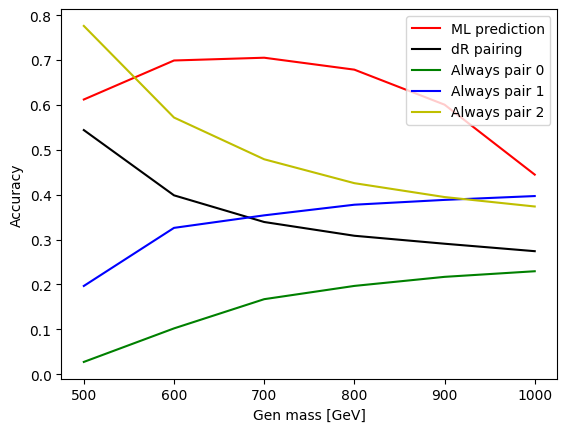

In [27]:
plt.plot(Masses, AccPred, "r", label = "ML prediction")
plt.plot(Masses, AccdR, "k", label = "dR pairing")
plt.plot(Masses, Acc0, "g", label = "Always pair 0")
plt.plot(Masses, Acc1, "b", label = "Always pair 1")
plt.plot(Masses, Acc2, "y", label = "Always pair 2")
plt.legend(loc="upper right")
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.savefig("plots/" + Model.name + "_Acc_vs_mass.png")

In [28]:
P1Mi = TestingDF.columns.get_loc("P1M")
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Pred"]]
TestingDF

,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M
0,1.270563,0.592479,0.457237,0.444398,0.752781,0.148789,0.580948,0.488222,0.564636,0.379613,0.450785,0.445276,1.192871,0.220795,53.401810,0.396414,0.826538,-1.889648,37.683247,0.253830,1.022705,2.150391,44.048386,0.142262,1.403320,2.746094,20.555641,1,500,450.785098,534.585277,472.124324,0,2,2,2,450.785098,472.124324,472.124324,472.124324
1,1.475435,0.547174,0.491401,0.419803,0.807320,0.257938,0.725030,0.534675,0.619392,0.519556,0.532629,0.386220,0.712402,2.030273,26.168791,0.319353,0.188324,-1.345215,35.911667,0.221728,0.081406,-2.320312,23.776711,0.166014,-1.630371,0.653198,26.844530,1,500,532.628989,629.852393,569.474171,0,2,0,2,532.628989,569.474171,532.628989,569.474171
2,1.161358,0.610406,0.422835,0.371498,0.708900,0.431600,0.491063,0.435224,0.431442,0.229310,0.330376,0.385469,-1.280762,2.541504,43.752235,0.319098,-0.842651,-1.010498,38.148968,0.201867,-1.448730,0.814819,20.165089,0.200784,-0.624023,-1.872314,30.021049,1,500,570.249968,463.143578,330.376313,2,1,1,1,330.376313,463.143578,463.143578,463.143578
3,1.439718,0.678990,0.456938,0.339597,0.977554,0.303681,0.657862,0.573336,0.488924,0.177533,0.333229,0.499242,-0.684570,-0.824707,31.187063,0.468612,-0.261902,1.964355,44.088165,0.155829,-1.869385,2.106445,17.148842,0.134420,-1.299805,-1.028320,18.508249,1,500,640.617487,615.598976,333.228788,2,2,1,1,333.228788,333.228788,615.598976,615.598976
4,2.699749,0.675547,0.536849,0.452600,1.823807,0.253359,1.449358,0.442720,1.221906,0.411076,0.816491,1.287038,-0.572021,2.635254,115.961243,0.640474,-0.784302,-0.786865,112.643608,0.387331,-0.167114,-0.370422,57.598236,0.267378,0.160522,-1.045410,28.222166,1,500,1038.583151,946.039040,816.490894,2,2,2,2,816.490894,816.490894,816.490894,816.490894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.166589,0.591774,0.576928,0.485911,0.690357,0.175872,0.673037,0.128909,0.566859,0.269989,0.400973,0.580431,-0.787231,-2.472656,61.770523,0.199628,-0.520996,0.828247,25.457657,0.141492,-1.962158,1.009766,14.670464,0.138341,-1.006348,0.296143,22.974472,1,1000,433.114600,400.973399,418.424179,1,0,0,2,400.973399,433.114600,433.114600,418.424179
299996,2.218874,0.525513,0.446088,0.309142,1.166048,0.902160,0.989812,0.930570,0.685946,0.667445,0.676696,0.673639,0.838867,-3.100098,44.545891,0.534680,1.001953,0.568726,40.094761,0.453578,0.952515,-0.905151,41.700886,0.272741,-0.549316,2.650879,24.410095,1,1000,1034.103896,960.191267,676.695534,2,1,0,2,676.695534,960.191267,1034.103896,676.695534
299997,2.551666,0.608357,0.405521,0.399058,1.552324,0.859959,1.034753,0.920880,1.018263,0.652701,0.835482,0.487786,-1.555176,1.605713,67.859367,0.470927,0.623169,-2.262207,38.836422,0.423128,-0.494629,0.689331,30.703781,0.421724,-1.281250,-1.694824,53.564262,1,1000,1206.141640,977.816285,835.481783,2,2,1,2,835.481783,835.481783,977.816285,835.481783
299998,2.015078,0.613639,0.496935,0.240186,1.236529,0.651030,1.001363,0.853832,0.483993,0.392136,0.438065,0.562967,-0.582764,1.727783,36.473480,0.511767,0.548096,-1.800293,58.024502,0.443341,-0.395081,-1.592041,22.260691,0.281440,-0.571045,0.714600,29.145082,1,1000,943.779885,927.597488,438.064941,2,1,0,2,438.064941,927.597488,943.779885,438.064941


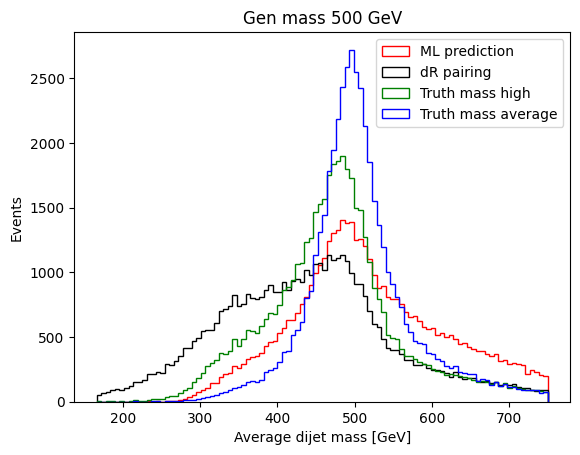

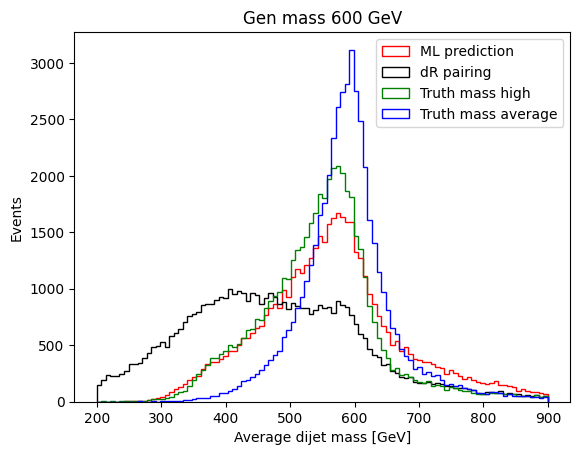

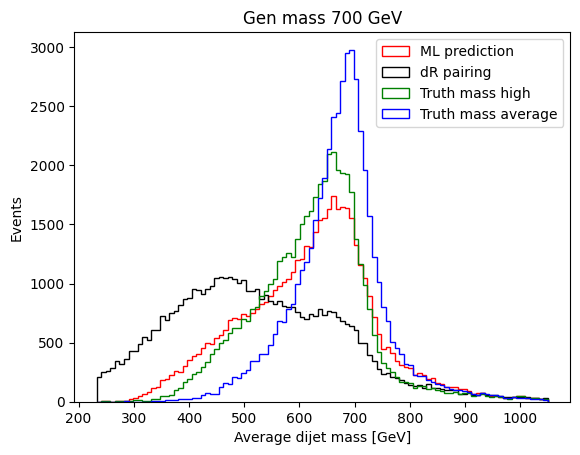

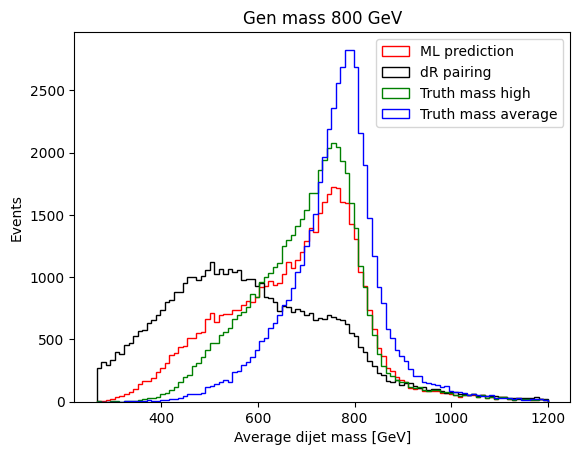

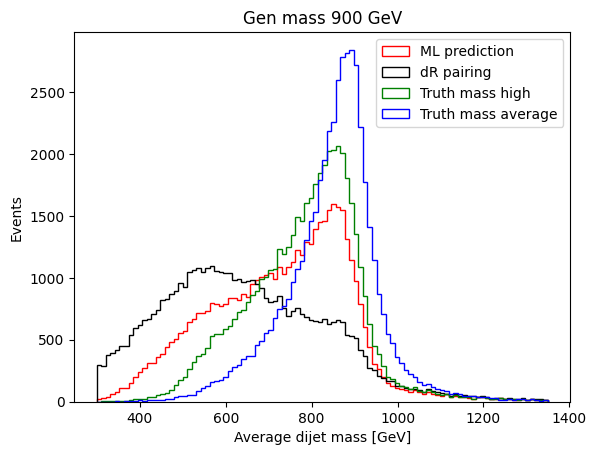

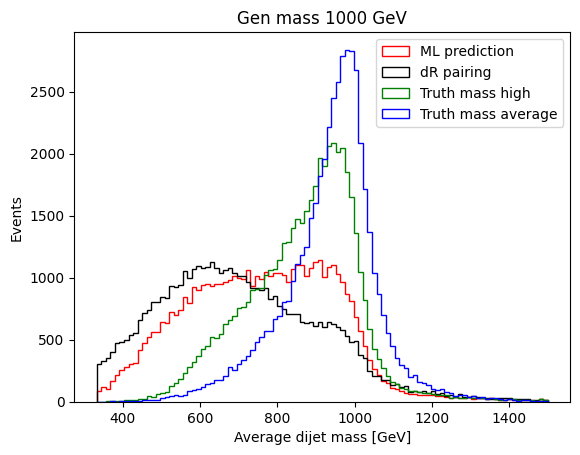

In [29]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.show()